In [1]:
# File system
import os
import shutil

import numpy as np
import time
from tqdm import tqdm
import regex
from collections import defaultdict

In [2]:
def load_dataset(data_source_filename):
    print("Loading %s... " % data_source_filename.split("/")[-1], end="")
    t = time.time()
    dataset = dict()
    with np.load(data_source_filename, allow_pickle=True) as source_file:
        for key in source_file.keys():
          # print(key)
          dataset[key] = source_file[key].tolist()
        print("done (%.1fs)" % (time.time()-t), flush=True)
        return dataset

base_path = "data"
assert os.path.exists(base_path)
    
data_source_filenames = [os.path.join(base_path, fn) for fn in os.listdir(base_path)
                            if os.path.isfile(os.path.join(base_path, fn)) and fn[-3:]=='npz']
data_source_filenames

['data/StClare_facs_danish.npz',
 'data/SDHK_Latin.npz',
 'data/StClare_facs_latin.npz',
 'data/StClare_dipl_danish.npz',
 'data/StClare_dipl_latin.npz',
 'data/SDHK_Swedish.npz',
 'data/Colonia.npz',
 'data/SemEval2015.npz']

In [3]:
data_source_filename = data_source_filenames[-1]
dataset = load_dataset(data_source_filename)

Loading SemEval2015.npz... done (0.9s)


## 1 Model correlation

#### Unpack model prediction

In [4]:
models = ["temporallm", "linearsvc", "gaussianprocess"]
configs = ["word_ngram_1", "word_ngram_2", "word_ngram_3", "character_ngram_1", "character_ngram_2", "character_ngram_3"]
#["baseline", "linearsvc", "multinomial_naive_bayes", "gaussian_naive_bayes", "svc", "gaussianprocess", "temporallm"]

predictions = defaultdict(lambda:defaultdict(list))
gold = {}

datasets = iter(load_dataset(data_source) for data_source in data_source_filenames)
datasets_names = list(map(lambda x: x[x.rfind("/")+1:x.rfind(".")], data_source_filenames))


for i, (dataset, name) in enumerate(zip(datasets, datasets_names)):
    gold[name] = dataset["linearsvc"]["bow_words"]["y_true"]

    for model in models:

        try:
            model_results = dataset[model]
        except KeyError:
            predictions[name][model] = None
            print("Model not found", name, model)
        
        for config in configs:
            #if model == "temporallm":

            #    config = config.replace("character", "char")
            #    config = config.replace("ngram_", "")
            #    config+="_25"
    
            try:
                result = model_results[config]
            except KeyError:
                result = {"y_pred":np.zeros(len(dataset["folds"]["test"]))}

            try:
                predictions[name][model+"_"+config] = result["y_pred"]
                predictions["all"][model+"_"+config]+= list(np.array(result["y_pred"]).flatten())
            except KeyError:
                print("", name, model+"_"+config)
             

Loading StClare_facs_danish.npz... done (0.0s)
Loading SDHK_Latin.npz... done (1.6s)
Loading StClare_facs_latin.npz... done (0.1s)
Loading StClare_dipl_danish.npz... done (0.1s)
Loading StClare_dipl_latin.npz... done (0.1s)
Loading SDHK_Swedish.npz... done (0.6s)
Loading Colonia.npz... done (5.8s)
Loading SemEval2015.npz... done (0.2s)


In [5]:
from scipy.stats import kendalltau, spearmanr

In [6]:
to_ordinal = list(range(900, 2001, 25))

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, product

cms = []
pms = []
mms = []

for dataset, models in tqdm(predictions.items()):

    cm = np.zeros((len(models), len(models)))
    pm = np.zeros((len(models), len(models)))
    
#    for (model1, model2), (i, j) in zip(combinations(models, 2), combinations(range(len(models)), 2)):
    for (model1, model2), (i, j) in zip(product(models, repeat=2), product(range(len(models)), repeat=2)):
        
        model1_ordinal = list(map(lambda x:to_ordinal.index(x)+1 if x in to_ordinal else np.nan, np.array(models[model1]).flatten().astype(int)))
        model2_ordinal = list(map(lambda x:to_ordinal.index(x)+1 if x in to_ordinal else np.nan, np.array(models[model2]).flatten().astype(int)))
        

        try:
            kendall = kendalltau(models[model1], models[model2], nan_policy="omit")
            cm[i, j] = kendall.correlation
            pm[i, j] = kendall.pvalue                    
        except ValueError:
            kendall = np.nan
    mms.append(list(models.keys()))
    cms.append(cm)
    pms.append(pm)

100%|██████████| 9/9 [00:21<00:00,  2.35s/it]


StClare_facs_danish


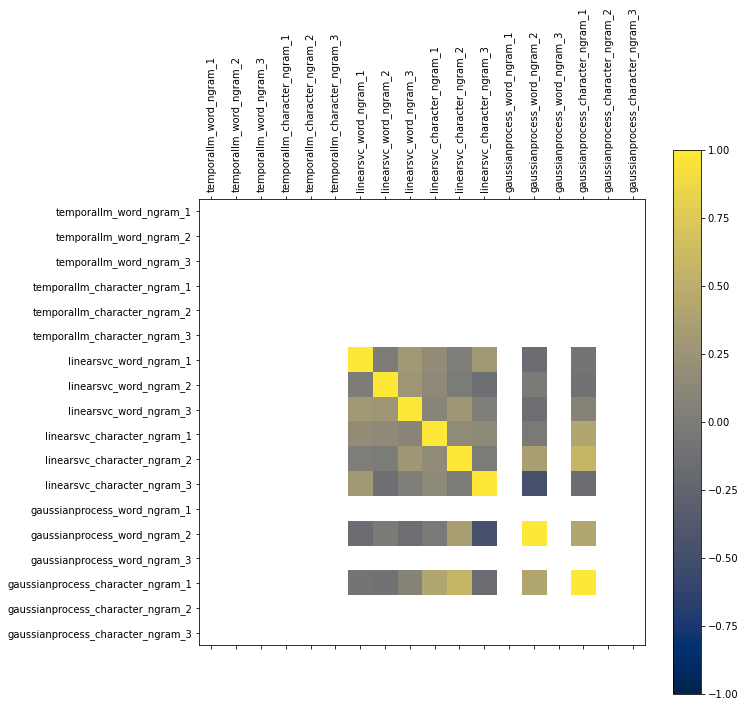

all


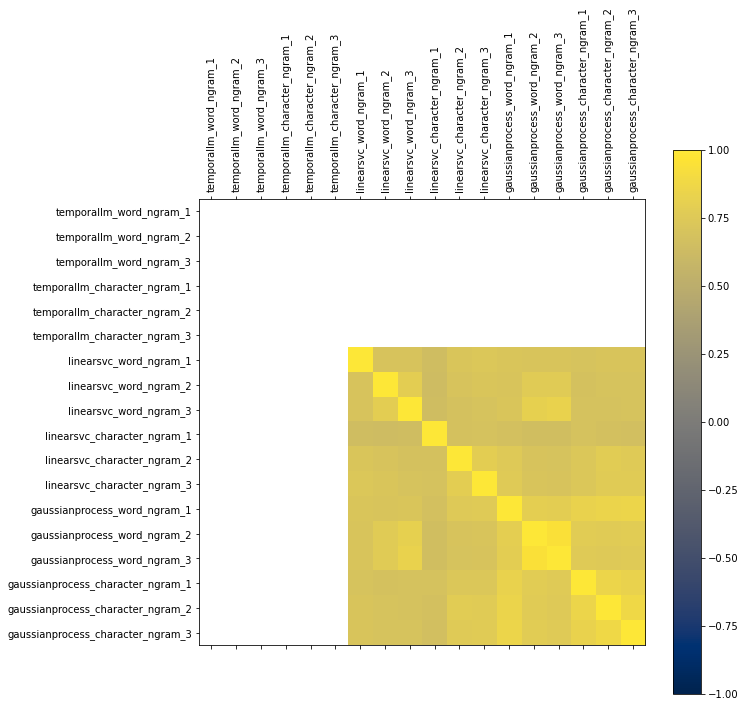

SDHK_Latin


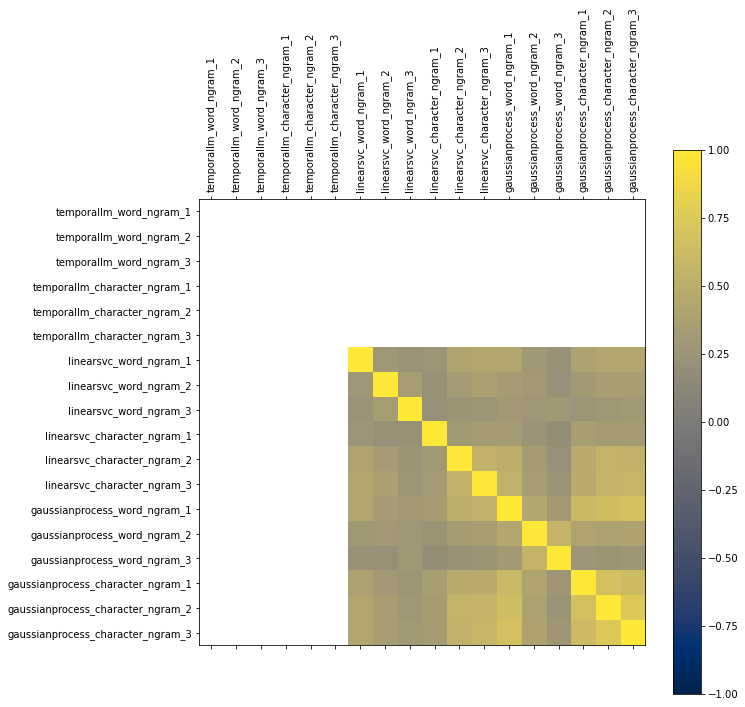

StClare_facs_latin


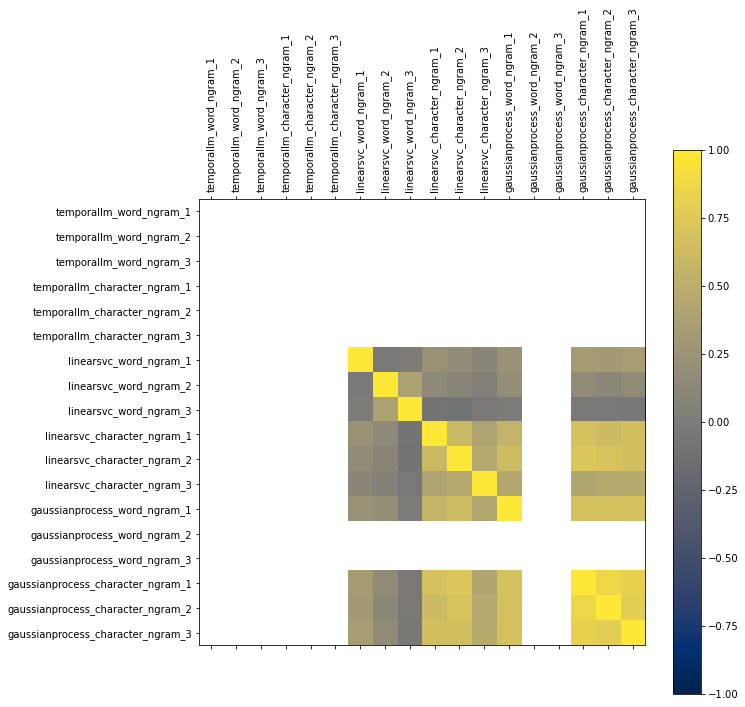

StClare_dipl_danish


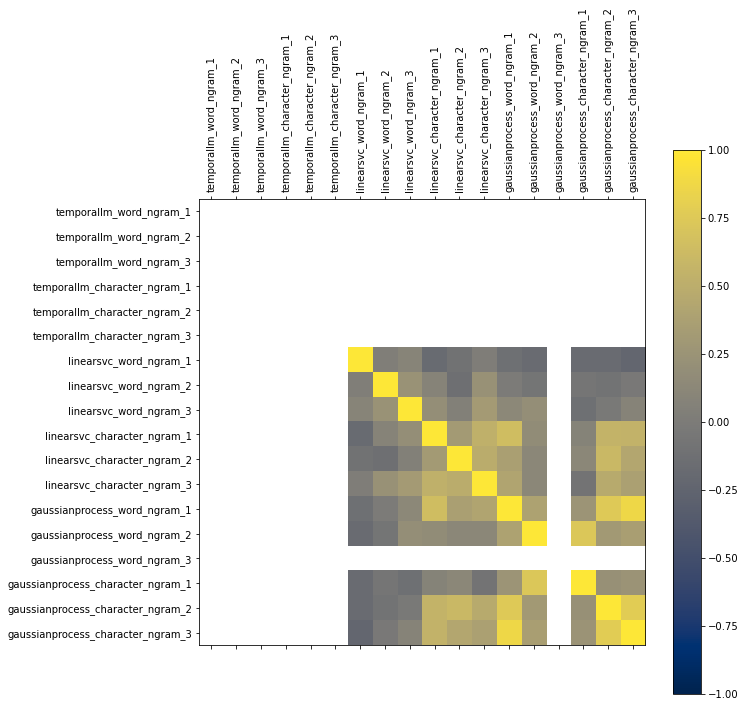

StClare_dipl_latin


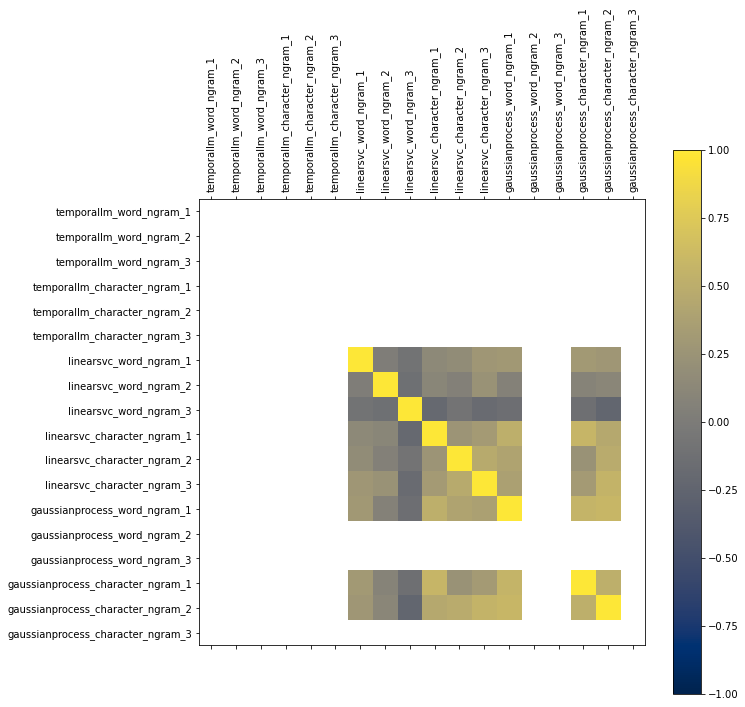

SDHK_Swedish


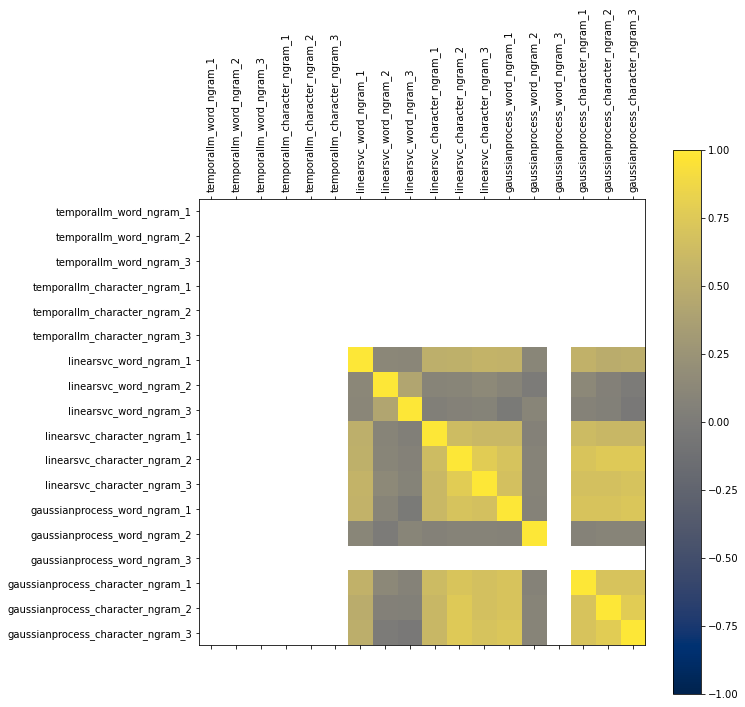

Colonia


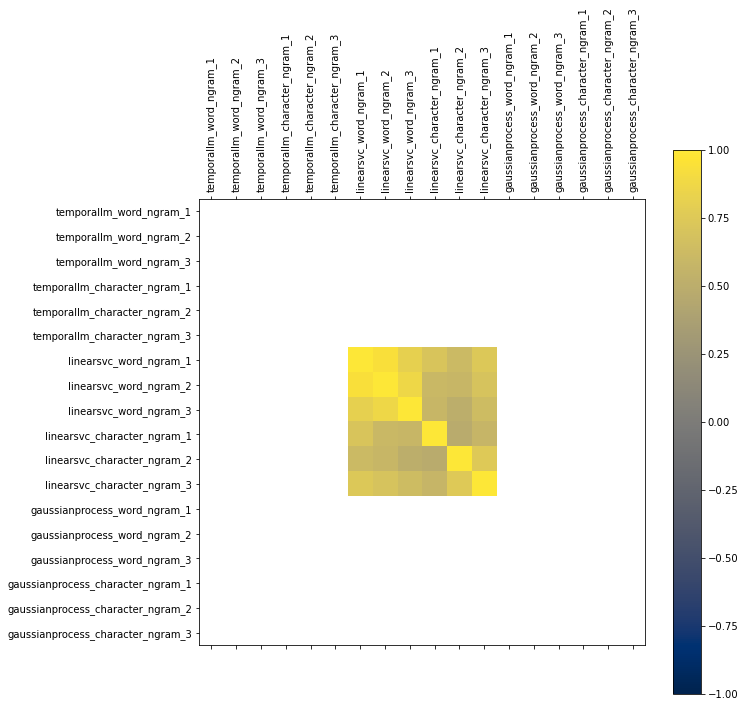

SemEval2015


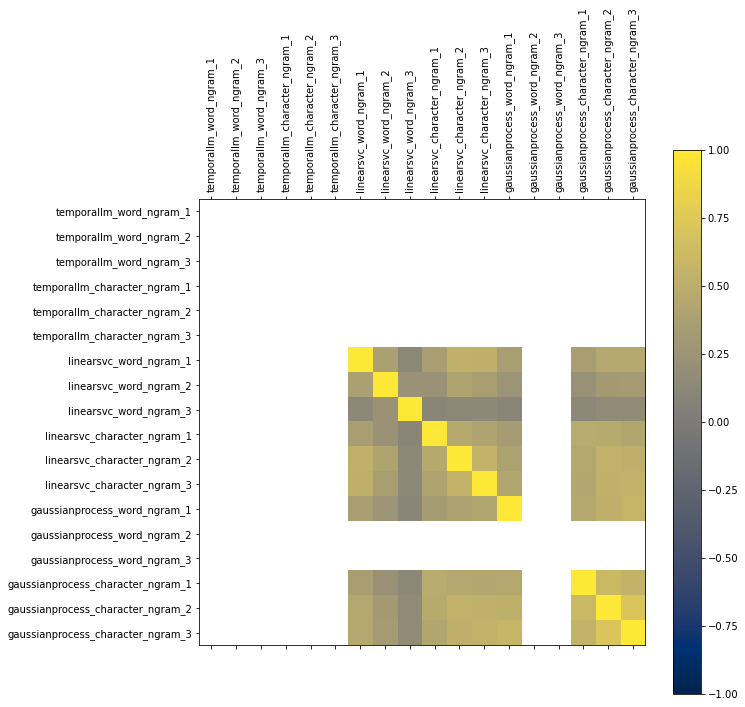

In [8]:
i = 5
for i in range(len(cms)):
    print(list(predictions.keys())[i])

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cms[i].T, cmap=plt.cm.cividis, vmin=-1, vmax=1)
    fig.colorbar(cax)
    plt.xticks(range(0, len(mms[i])))
    plt.yticks(range(0, len(mms[i])))
    ax.set_yticklabels(mms[i])
    ax.set_xticklabels(mms[i], rotation=90)
    plt.show()

In [9]:
predictions["all"].keys()

dict_keys(['temporallm_word_ngram_1', 'temporallm_word_ngram_2', 'temporallm_word_ngram_3', 'temporallm_character_ngram_1', 'temporallm_character_ngram_2', 'temporallm_character_ngram_3', 'linearsvc_word_ngram_1', 'linearsvc_word_ngram_2', 'linearsvc_word_ngram_3', 'linearsvc_character_ngram_1', 'linearsvc_character_ngram_2', 'linearsvc_character_ngram_3', 'gaussianprocess_word_ngram_1', 'gaussianprocess_word_ngram_2', 'gaussianprocess_word_ngram_3', 'gaussianprocess_character_ngram_1', 'gaussianprocess_character_ngram_2', 'gaussianprocess_character_ngram_3'])

In [10]:
dataset.keys()

AttributeError: 'str' object has no attribute 'keys'